- Leveraging advanced image processing and analysis techniques to segment/detect HEx: Code for Visualization

# IMPORTING REQUIRED LIBRARIES

In [1]:
# Libraries for image preprocessing
import os # for interating with the file system
import cv2 as cv # for image processing
import numpy as np # for numerical computation and data analysis
import matplotlib.pyplot as plt # for creating visualizations
import scipy as sp # for image processing, signal processing, optimization, and more
import scipy.ndimage as ndimage # provides functions for n-dimensional image processing, including filtering, segmentation, and morphology operations
import math # for mathematical functions and constants
from sklearn.metrics import confusion_matrix # for computing various evaluation metrics

## APPLYING GRAYSCALE MORPHOLOGICAL OPERATIONS & THRESHOLDING TECHNIQUES FOR HEx SEGMENTATION

**Working with some instances of the training dataset**
 
    Input image -> Processing -> Enhanced image
    
    Enhanced image -> Segmentation -> Detected regions

**Input image:**  visualizing the training (2 instances) dataset

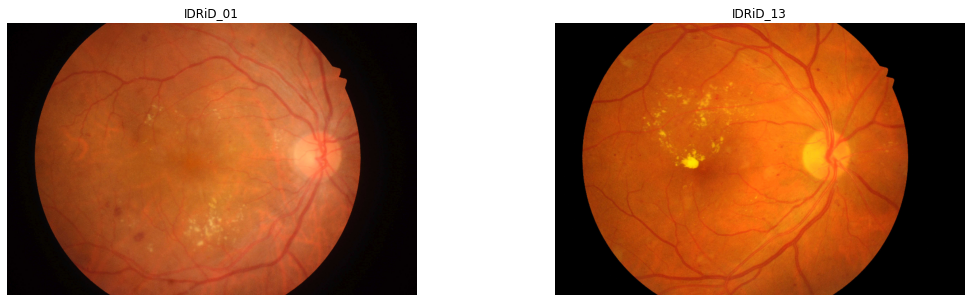

In [2]:
tr_image01 = cv.imread("Retinal Lesions Segmentation/data/images/training/IDRiD_01.jpg") # Set path to training image (01)
img01 = cv.resize(tr_image01, dsize = None, fx = 0.2, fy = 0.2, interpolation = cv.INTER_CUBIC) # INTER_CUBIC interpolation is used to improve the quality of the resized image.

tr_image13 = cv.imread("Retinal Lesions Segmentation/data/images/training/IDRiD_13.jpg") # Set path to training image (13)
img13 = cv.resize(tr_image13, dsize = None, fx = 0.2, fy = 0.2, interpolation = cv.INTER_CUBIC) # INTER_CUBIC interpolation is used to improve the quality of the resized image.
    
# Displaying img01 & img13
plt.figure(figsize = (18, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(img01, cv.COLOR_BGR2RGB)); plt.title("IDRiD_01"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(img13, cv.COLOR_BGR2RGB)); plt.title("IDRiD_13"); plt.axis("off")
plt.show()

# IMAGE PREPROCESSING

**(1) OPTIC DISC REMOVAL:**

     This is to address the challenge posed by the optical disc, which has a similar intensity value to the candidate region of interest (HEx).
     
     Defining functions for optic disc removal: 
     (a) Gamma correction: a non-linear adjustment of pixel intensities to improve image contrast. 
     (b) Linear stretching: a contrast enhancement technique that expands the range of pixel intensities in an image.

In [3]:
def gammaCorrection(image, gamma):
    c = 255**(1-gamma)
    return (c *(image**gamma)).astype("uint8")

def linearStretching(img):
    hf_counts, hf_bins = np.histogram(img.flatten(), bins = 256, range = (0, 255))
    s1, s2 =  int(np.argwhere(hf_counts > 0)[0]), int(np.argwhere(hf_counts > 0)[-1])
    t1, t2 = 0, 255
    return ((img-s1)*((t2-t1)/(s2-s1)+t1)).astype("uint8")

    Code for optic disc removal

In [4]:
# Set the background to zero
_, _, red = cv.split(img01) # Splits input image into BGR colour channel
_, backgroundmask = cv.threshold(red, thresh = 30, maxval = 1, type = cv.THRESH_BINARY) # Threshold the red channel to create a binary background mask
image = cv.bitwise_and(img01, img01, mask = backgroundmask) # Finds intersection between img01 & backgroundmask. Sets pixels outside the background region to zero, effectively removing the background

# Segmentation of the optical disc 
image_ms = cv.pyrMeanShiftFiltering(image, sp = 10, sr = 20) # Smooths the image while shifting each pixel towards the mode of its neighborhood
gray = cv.cvtColor(image_ms, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize = (30, 30))
image_cl = clahe.apply(gray)
image_gc = gammaCorrection(image_cl, 2.5)
image_ls = linearStretching(image_gc)
circles = cv.HoughCircles(image_ls, method = cv.HOUGH_GRADIENT, dp = 1, minDist = 5, param1 = 100, param2 = 10, minRadius = 10, maxRadius = 120) # Detects circles in the preprocessed image and returns the detected circles as a list of parameters

# Create a mask image with the same size as the original image
mask = np.zeros_like(image_ls)
for i in range(len(circles)):
    circle = circles[0][i]
    center = (int(circle[0]), int(circle[1]))
    radius = int(circle[2])
    cv.circle(mask, center, radius, 255, -1)  

# Invert the mask and apply it to the original image to remove the region inside the circles    
inverted_mask = cv.bitwise_not(mask)
removed_disc = cv.bitwise_and(img01, img01, mask = inverted_mask) 

    Displaying all the steps involved in the optic disc segmentation for visualization

(-0.5, 857.5, 569.5, -0.5)

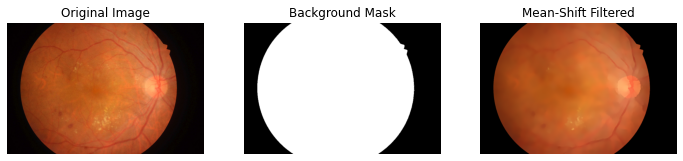

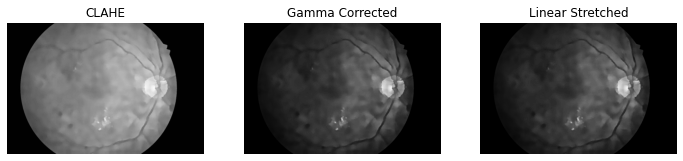

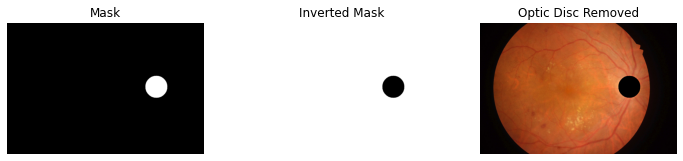

In [5]:
plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(cv.cvtColor(img01, cv.COLOR_BGR2RGB)); plt.title("Original Image"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(backgroundmask, cmap = "gray"); plt.title("Background Mask"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(cv.cvtColor(image_ms, cv.COLOR_BGR2RGB)); plt.title("Mean-Shift Filtered"); plt.axis("off")

plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(image_cl, cmap = "gray"); plt.title("CLAHE"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(image_gc, cmap = "gray"); plt.title("Gamma Corrected"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(image_ls, cmap = "gray"); plt.title("Linear Stretched"); plt.axis("off")

plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(mask, cmap = "gray"); plt.title("Mask"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(inverted_mask, cmap = "gray"); plt.title("Inverted Mask"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(cv.cvtColor(removed_disc, cv.COLOR_BGR2RGB)); plt.title("Optic Disc Removed"); plt.axis("off")

**(2) GRAYSCALE MORPHOLOGICAL OPERATIONS & THRESHOLDING**

    >> Removed optic disc -> resize -> b, g, r colour conversion

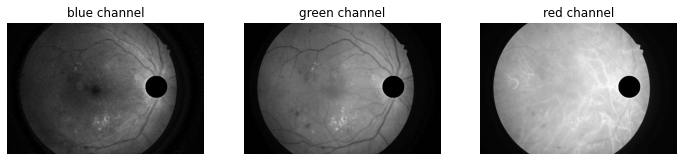

In [6]:
removed_disc = cv.resize(removed_disc, (4288, 2848), interpolation = cv.INTER_CUBIC) # Return the image to its orginal size and split it into b, g, r
aspect_ratio = min([1152/removed_disc.shape[0], 1500/removed_disc.shape[1]]) # Calculate the minimum ratio between the target width(1500) and height(1152), and then resize the image to a new size.
img = cv.resize(removed_disc, (int(removed_disc.shape[1]*aspect_ratio), int(removed_disc.shape[0]*aspect_ratio)), interpolation = cv.INTER_CUBIC) # INTER_CUBIC interpolation is used to improve the quality of the resized image.
b, g, r = cv.split(img) # b,g,r colour conversion

# Displaying b,g,r image channels
plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(b, cmap = "gray"); plt.title("blue channel"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(g, cmap = "gray"); plt.title("green channel"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(r, cmap = "gray"); plt.title("red channel"); plt.axis("off")
plt.show()

**Applying Image processing/enhancement & segmentation/detection techniques on green image channel**

     >> medianBlur -> CLAHE -> morphological operation (BLACKHAT & TOPHAT) -> thresholding

     i: ORIGINAL IMAGE

(-0.5, 1499.5, 995.5, -0.5)

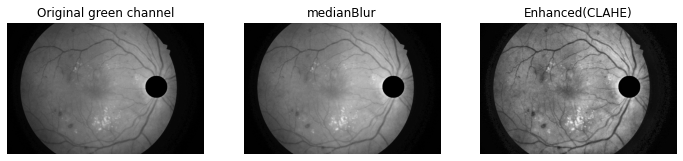

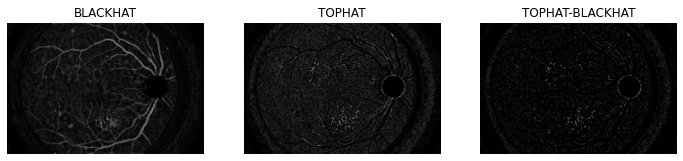

In [7]:
image_median = cv.medianBlur(g, 3) # applies median blur filter to reduce noise and smooth out small details.
clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize = (10,10)) # improves image contrast by redistributing pixel intensities. clip limit determines the maximum amount of contrast enhancement applied to each pixel, while the tile size defines the size of the local neighborhood used to compute the histogram equalization.
image_enhanced = clahe.apply(image_median) # applies clahe on image_median.

kernel_bh = cv.getStructuringElement(cv.MORPH_ELLIPSE,(40,40)) # creates a structuring element (a shape mask used in morphological operations) in the shape of an ellipse with dimensions of 200x200 pixels.
image_bh = cv.morphologyEx(image_enhanced,cv.MORPH_BLACKHAT, kernel_bh) #  subtracts original image from the results of closing operation, to enhance contrast between dark regions in the image and background. 

kernel_th = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15)) # creates a structuring element in the shape of an ellipse with dimensions of 200x200 pixels.
image_th = cv.morphologyEx(image_enhanced,cv.MORPH_TOPHAT, kernel_th) # subtracts results of opening operation from original image, to enhance contrast between bright regions in the image and background. 

image_hex = cv.subtract(image_th,image_bh) # subtracts result of "black hat" from result of "top hat" operation, producing image with enhanced contrast and better defined features.
ret, image_hex_patch = cv.threshold(image_hex, 35, 255, cv.THRESH_BINARY) # applies a thresholding operation to the enhanced image, in order to create a binary mask that isolates regions of interest.    

# Displaying the original green channel and enhanced images
plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(g, cmap = "gray"); plt.title("Original green channel"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(image_median, cmap = "gray"); plt.title("medianBlur"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(image_enhanced, cmap = "gray"); plt.title("Enhanced(CLAHE)"); plt.axis("off")

plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(image_bh, cmap = "gray"); plt.title("BLACKHAT"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(image_th, cmap = "gray"); plt.title("TOPHAT"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(image_hex, cmap = "gray"); plt.title("TOPHAT-BLACKHAT"); plt.axis("off")

 **Applying Image processing/enhancement & segmentation/detection techniques on green image channel**

    >> medianBlur -> CLAHE -> morphological operation (BLACKHAT & TOPHAT) -> thresholding
    
    ii: RESIZED (HALVED) IMAGE

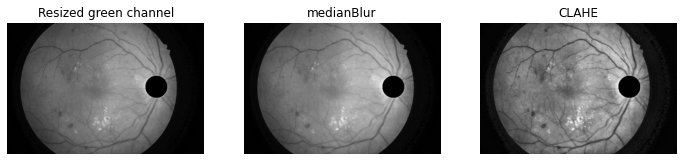

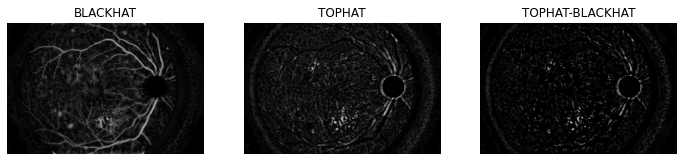

In [8]:
image_half = cv.resize(g,(int(img.shape[1]/2),int(img.shape[0]/2)),interpolation = cv.INTER_CUBIC)

image_median_half = cv.medianBlur(image_half,3)
clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize = (10,10))
image_enhanced_half = clahe.apply(image_median_half)

kernel_bh_h = cv.getStructuringElement(cv.MORPH_ELLIPSE,(35,35))
image_bh_half = cv.morphologyEx(image_enhanced_half,cv.MORPH_BLACKHAT, kernel_bh_h)

kernel_th_h = cv.getStructuringElement(cv.MORPH_ELLIPSE,(13,13))
image_th_half = cv.morphologyEx(image_enhanced_half,cv.MORPH_TOPHAT, kernel_th_h)

image_hex_half = cv.subtract(image_th_half,image_bh_half)
ret, image_hex_patch_half = cv.threshold(image_hex_half, 35, 255, cv.THRESH_BINARY)
image_hex_patch_half = cv.resize(image_hex_patch_half, (image_hex_patch.shape[1], image_hex_patch.shape[0]), interpolation=cv.INTER_NEAREST)   

# Displaying the resized green channel and enhanced images
plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(image_half, cmap = "gray"); plt.title("Resized green channel"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(image_median_half, cmap = "gray"); plt.title("medianBlur"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(image_enhanced_half, cmap = "gray"); plt.title("CLAHE"); plt.axis("off")

plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(image_bh_half, cmap = "gray"); plt.title("BLACKHAT"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(image_th_half, cmap = "gray"); plt.title("TOPHAT"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(image_hex_half, cmap = "gray"); plt.title("TOPHAT-BLACKHAT"); plt.axis("off")
plt.show()

     LAB Color Space Transformation

(-0.5, 1499.5, 995.5, -0.5)

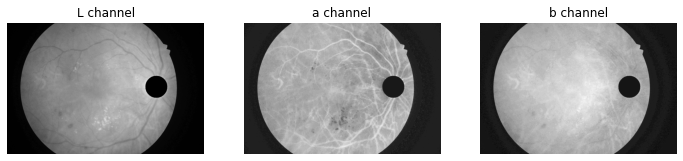

In [9]:
lab_image = cv.cvtColor(img, cv.COLOR_BGR2LAB) # converts image from BGR to LAB colour space
L, a, b = cv.split(lab_image) # splits image into L (luminance/lightness), a, and b (chromaticity) channels
ret, image_labt = cv.threshold(L, 4, 255, cv.THRESH_BINARY) # applies a binary threshold to the L channel

plt.figure(figsize = (12, 8))
plt.subplot(1, 3, 1); plt.imshow(L, cmap = "gray"); plt.title("L channel"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(a, cmap = "gray"); plt.title("a channel"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(b, cmap = "gray"); plt.title("b channel"); plt.axis("off")

    Performing erosion and binary mask to obtain a complete mask of the retinal image on L channel

(-0.5, 1499.5, 995.5, -0.5)

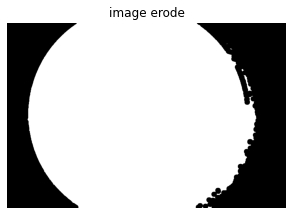

In [10]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15))  
image_erode = cv.erode(image_labt, kernel, iterations = 2)
image_erode = ndimage.binary_fill_holes(image_erode)
image_erode = np.array(image_erode,np.uint8)

# Displaying the image_erode
plt.figure(figsize = (5, 5))
plt.imshow(image_erode, cmap = "gray"); plt.title("image erode"); plt.axis("off")

    >> COMBINING FEATURES OF ORIGINAL AND RESIZED IMAGE TO REFINE SEGMENTATION

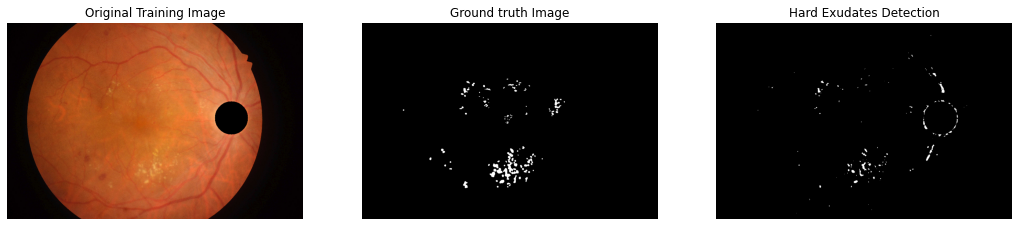

In [11]:
image_both = cv.bitwise_or(image_hex_patch, image_hex_patch_half) # Bitwise or Operation of original and resized images
# image_erode_resized = cv.resize(image_erode, (image_both.shape[1], image_both.shape[0]), interpolation=cv.INTER_CUBIC) # Resize image_erode to match the size of image_both
image_both = cv.bitwise_and(image_both, image_erode) # Bitwise and Operation of image_both and the eroded lightness patch
image_both = cv.resize(image_both, (4288, 2848), interpolation=cv.INTER_CUBIC) # Resizing to original

hex_image = cv.imread("Retinal Lesions Segmentation/data/groundtruths/training/hard exudates/IDRiD_01_EX.tif")
hex_image_gray = cv.cvtColor(hex_image, cv.COLOR_BGR2GRAY)

# Displaying the original, groundtruth and enhanced images
plt.figure(figsize = (18, 5))
plt.subplot(1, 3, 1); plt.imshow(cv.cvtColor(removed_disc, cv.COLOR_BGR2RGB)); plt.title("Original Training Image"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(hex_image_gray, cmap = "gray"); plt.title("Ground truth Image"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(image_both, cmap = "gray"); plt.title("Hard Exudates Detection"); plt.axis("off")
plt.show()